In [47]:
import matplotlib.patches as patches  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from matplotlib.lines import Line2D  # type: ignore
import numpy as np  # type: ignore
import random

In [48]:
BOUNDS_ESPESSURE = (0.2, 1.5)  # mm
BOUNDS_DIAMETER = (10, 50)  # mm
BOUNDS_POSITION = (0, 1000)  # m

NUM_SENSORS = 6
NUM_PARAMETERS = 3
NUM_VARIABLES = NUM_SENSORS * NUM_PARAMETERS

ESPESSURE_INDEX = 0
DIAMETER_INDEX = 1
POSITION_INDEX = 2

In [49]:
NUM_ITERATIONS = 10_000
NUM_PARTICLES = 1_000
EARLY_STOPPING_PATIENCE = 30

In [50]:
w = 0.5
c1 = 1
c2 = 2

In [51]:
def circles_intersect(center1, diameter1, center2, diameter2):
    radius1 = diameter1 / 2
    radius2 = diameter2 / 2
    dist = abs(center1 - center2)

    return dist <= (radius1 + radius2)

In [52]:
def get_elements_in_chunks(lst, chunk_size=NUM_PARAMETERS):
    return [lst[i : i + chunk_size] for i in range(0, len(lst), chunk_size)]

In [53]:
def is_valid_position(new_sensor, sensors):
    grouped_sensors = get_elements_in_chunks(sensors)
    if not (
        (BOUNDS_ESPESSURE[0] < new_sensor[ESPESSURE_INDEX] < BOUNDS_ESPESSURE[1])
        and (BOUNDS_DIAMETER[0] < new_sensor[DIAMETER_INDEX] < BOUNDS_DIAMETER[1])
        and (BOUNDS_POSITION[0] < new_sensor[POSITION_INDEX] < BOUNDS_POSITION[1]) 
        and (BOUNDS_POSITION[0] < new_sensor[POSITION_INDEX] - new_sensor[DIAMETER_INDEX]) 
        and (BOUNDS_POSITION[1] > new_sensor[POSITION_INDEX] + new_sensor[DIAMETER_INDEX]) 
    ):
        return False
    
    for sensor in grouped_sensors:
        if not (
            sensor[ESPESSURE_INDEX] == new_sensor[ESPESSURE_INDEX]
            and sensor[DIAMETER_INDEX] == new_sensor[DIAMETER_INDEX]
            and sensor[POSITION_INDEX] == new_sensor[POSITION_INDEX]
        ) and circles_intersect(
            sensor[POSITION_INDEX],
            sensor[DIAMETER_INDEX],
            new_sensor[POSITION_INDEX],
            new_sensor[DIAMETER_INDEX],
        ):
            return False
    return True

In [54]:
def generate_sensor(sensors):
    while True:
        sensor = [
            np.random.uniform(*BOUNDS_ESPESSURE),
            np.random.uniform(*BOUNDS_DIAMETER),
            np.random.uniform(*BOUNDS_POSITION),
        ]

        if is_valid_position(sensor, sensors):
            break

    return sensor

In [55]:
def generate_sensors():
    sensors = []

    for _ in range(NUM_SENSORS):

        sensor = generate_sensor(sensors)
        sensors.extend(sensor)

    return sensors

In [56]:
def calculate_sensitivity(D, e, x, v=0.45, E=2e9):
    sens = 3 / 8 * (1 + v) * (D / 2) ** 2 / (E * e**2)
    s = 5.2e-6 * x + sens
    return s

In [57]:
def calculate_linearity(D, e, x):
    lin = (
        0.9509
        + 0.2274 * e
        - 0.0045 * D
        - 0.0863 * e**2
        + 0.0013 * e * D
        + 1.2732e-5 * D**2
    )
    l = -0.019 * x + lin
    return l

In [58]:
def cost_function(position):
    sensors = get_elements_in_chunks(position)
    total_sensitivity = 0
    total_linearity = 0

    for sensor in sensors:
        D = sensor[DIAMETER_INDEX]
        e = sensor[ESPESSURE_INDEX]
        x = sensor[POSITION_INDEX] / 1000

        total_sensitivity += calculate_sensitivity(D, e, x)
        total_linearity += calculate_linearity(D, e, x)

    return (total_sensitivity, total_linearity)

In [59]:
def generate_particle():
    sensors = generate_sensors()

    return {
        "position": sensors,
        "score": cost_function(sensors),
        "velocity": random.random(),
        "pbest": [sensors],
    }

In [60]:
def calculate_velocity(w, x, v, c1, c2, pbest, gbest):
    r1 = random.random()
    r2 = random.random()

    return w * v + c1 * r1 * (np.array(pbest) - x) + c2 * r2 * (np.array(gbest) - x)

In [61]:
def get_non_dominated_particles(positions):
    is_position_dominated = [False] * len(positions)

    for i in range(len(positions)):
        for j in range(len(positions)):
            if i != j:
                y1_i, y2_i = cost_function(positions[i])
                y1_j, y2_j = cost_function(positions[j])

                if (
                    (y1_j >= y1_i)
                    and (y2_j >= y2_i)
                    and ((y1_j > y1_i) or (y2_j > y2_i))
                ):
                    is_position_dominated[i] = True
                    break

    return [
        positions[i] for i in range(len(positions)) if is_position_dominated[i] is False
    ]

In [62]:
def fix_position(sensors):
    grouped_sensors = get_elements_in_chunks(sensors)
    fixed_position = []
    for sensor in grouped_sensors:
        if not is_valid_position(sensor, fixed_position):
            sensor = generate_sensor(fixed_position)

        fixed_position.extend(sensor)

    return fixed_position

In [63]:
def update_position(particles, w, c1, c2, gbest):
    if gbest is None:
        gbest = particles[0]["pbest"]

    for particle in particles:
        particle["velocity"] = calculate_velocity(
            w,
            particle["position"],
            particle["velocity"],
            c1,
            c2,
            random.choice(particle["pbest"]),
            random.choice(gbest),
        )

        particle["position"] = particle["position"] + particle["velocity"]
        particle["position"] = fix_position(particle["position"])
        particle["score"] = cost_function(particle["position"])

        pbest_copy = particle["pbest"].copy()
        pbest_copy.append(particle["position"])

        particle["pbest"] = get_non_dominated_particles(pbest_copy)

        gbest_copy = gbest.copy()
        gbest_copy.append(particle["position"])

        gbest = get_non_dominated_particles(gbest_copy)

    return gbest

In [64]:
def plot(particles):
    # Getting the score values as a NumPy array
    sensitivities = [particle["score"][0] for particle in particles]
    linearities = [particle["score"][1] for particle in particles]

    # Creating the plot for sensitivities
    plt.figure(figsize=(22, 4))
    plt.plot(
        sensitivities, [0] * len(sensitivities), marker="o", linestyle="", label="Sensitivities"
    )  # Plotting sensitivity points, y-axis fixed at zero
    plt.xlabel("Particle Index")  # Naming the x-axis
    plt.ylabel("Sensitivity")  # Naming the y-axis
    plt.title("Sensitivity Plot of Particles")
    plt.legend()  # Showing the legend
    plt.grid(True)  # Adding grid to the plot (optional)
    plt.show()  # Displaying the plot

    # Creating the plot for linearities
    plt.figure(figsize=(22, 4))
    plt.plot(
        linearities, [0] * len(linearities), marker="o", linestyle="", label="Linearities"
    )  # Plotting linearity points, y-axis fixed at zero
    plt.xlabel("Particle Index")  # Naming the x-axis
    plt.ylabel("Linearity")  # Naming the y-axis
    plt.title("Linearity Plot of Particles")
    plt.legend()  # Showing the legend
    plt.grid(True)  # Adding grid to the plot (optional)
    plt.show()  # Displaying the plot

In [65]:
particles = [generate_particle() for _ in range(NUM_PARTICLES)]

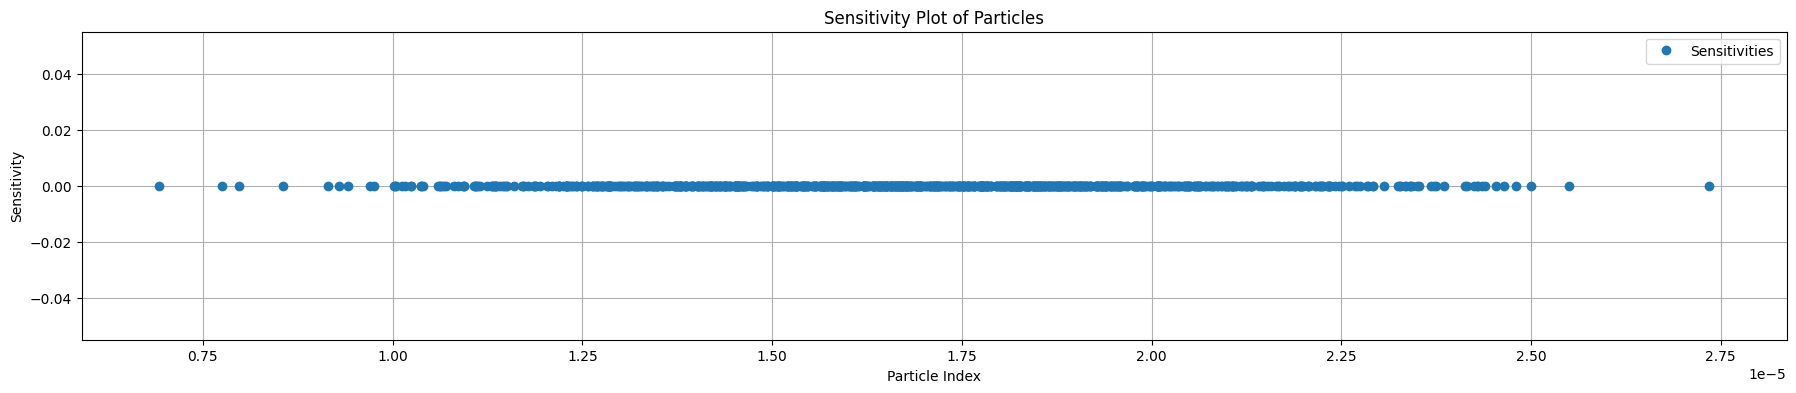

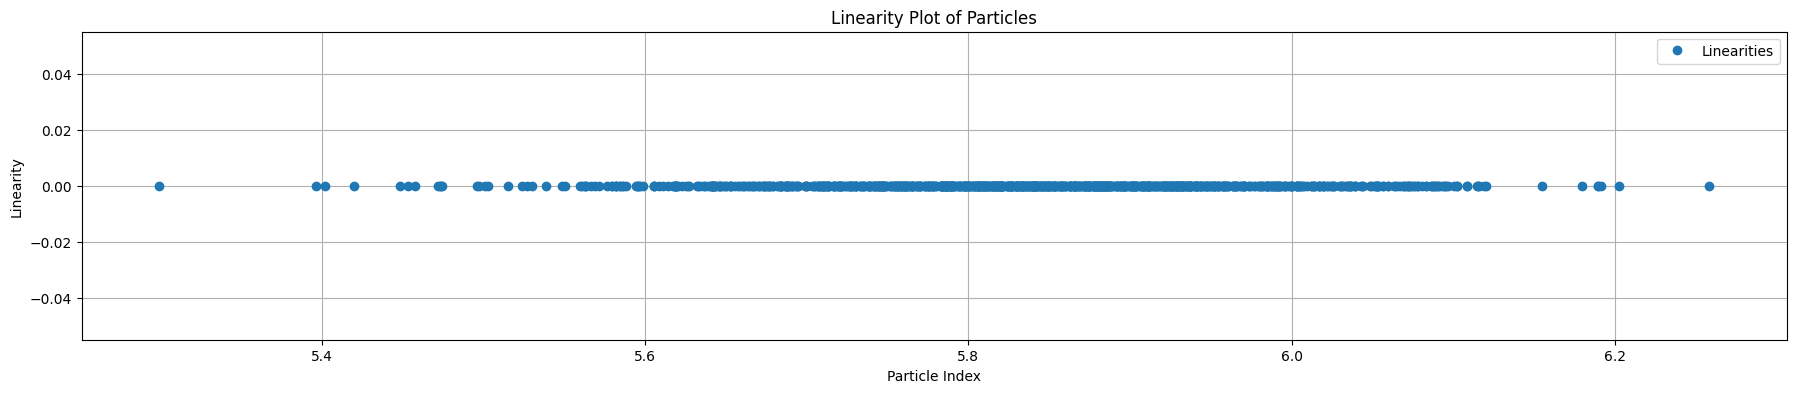

In [66]:
plot(particles)

In [67]:
i = 0
gbest = None
prev_len = 0
early_stopping_count = 0

while True:
    print(f"Iteration {i+1}")

    gbest = update_position(particles, w, c1, c2, gbest)

    if len(gbest) != prev_len:
        early_stopping_count = 0
        prev_len = len(gbest)
    else:
        early_stopping_count += 1

    i += 1

    if early_stopping_count == EARLY_STOPPING_PATIENCE:
        print("Early stopping!")
        break

    if i == NUM_ITERATIONS:
        break

Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration 77
Iteratio

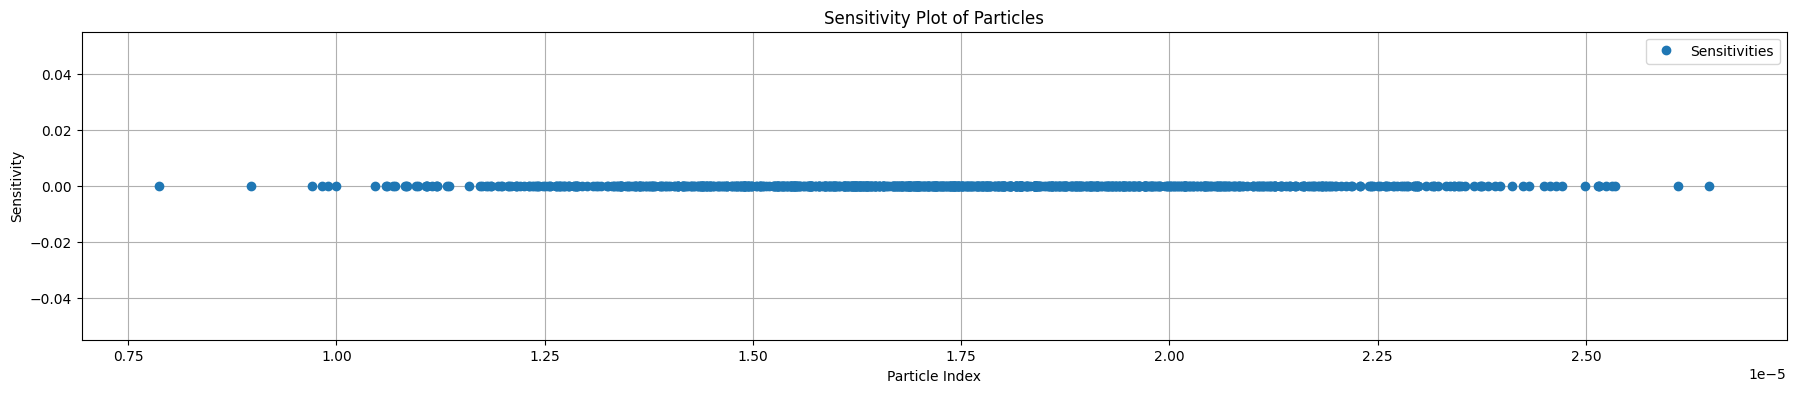

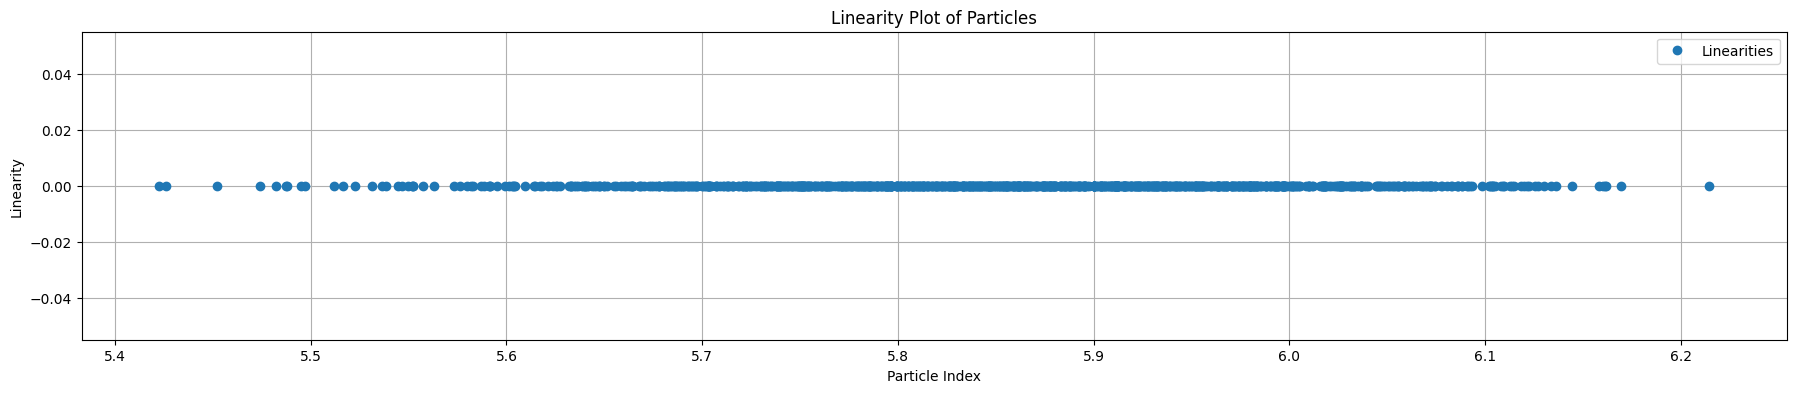

In [68]:
plot(particles)

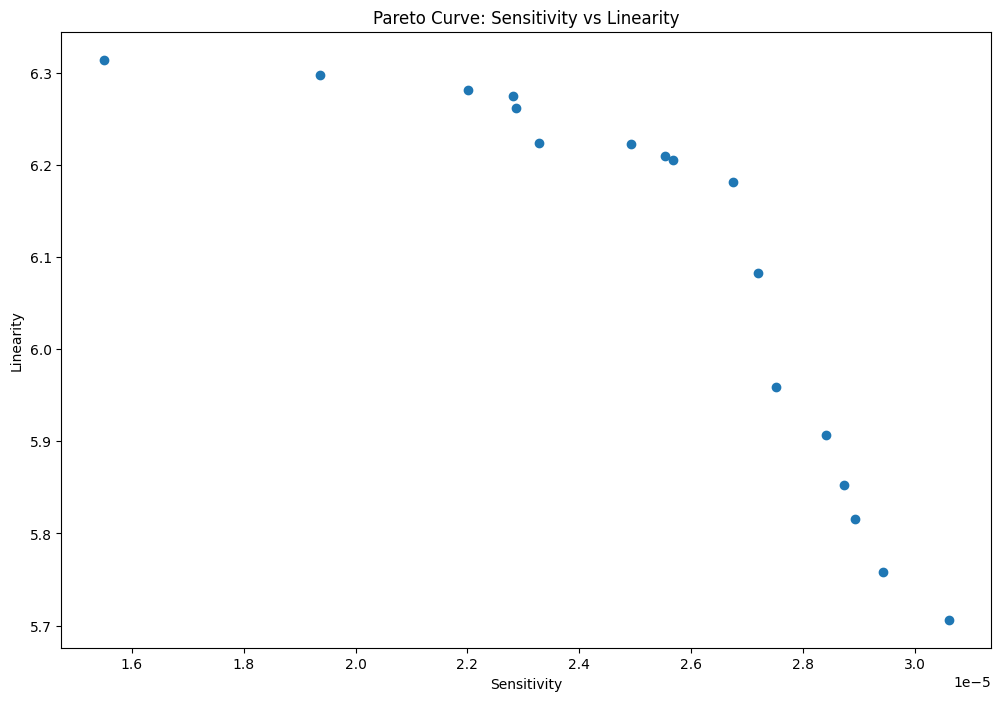

In [69]:
y1 = [cost_function(best)[0] for best in gbest]
y2 = [cost_function(best)[1] for best in gbest]

# Plotting the Pareto chart
plt.figure(figsize=(12, 8))
# Pontos não dominados
plt.scatter(y1, y2, marker="o", label="Non-dominated particles")
plt.xlabel("Sensitivity")
plt.ylabel("Linearity")
plt.title("Pareto Curve: Sensitivity vs Linearity")
plt.show()

In [70]:
def perpendicular_distance(point, line_start, line_end):
    line_vector = np.array(line_end) - np.array(line_start)
    point_vector = np.array(point) - np.array(line_start)
    line_length = np.linalg.norm(line_vector)
    if line_length == 0:
        return np.linalg.norm(point_vector)
    else:
        line_vector /= line_length
        projection = np.dot(point_vector, line_vector)
        perpendicular_vector = point_vector - projection * line_vector
        return np.linalg.norm(perpendicular_vector)

In [71]:
def find_knee_point(sorted_particles):
    knee_point = None
    max_distance = -np.inf
    for i in range(1, len(sorted_particles) - 1):
        dist = perpendicular_distance(
            cost_function(sorted_particles[i]),
            cost_function(sorted_particles[0]),
            cost_function(sorted_particles[-1]),
        )
        if dist > max_distance:
            max_distance = dist
            knee_point = sorted_particles[i]
    return knee_point

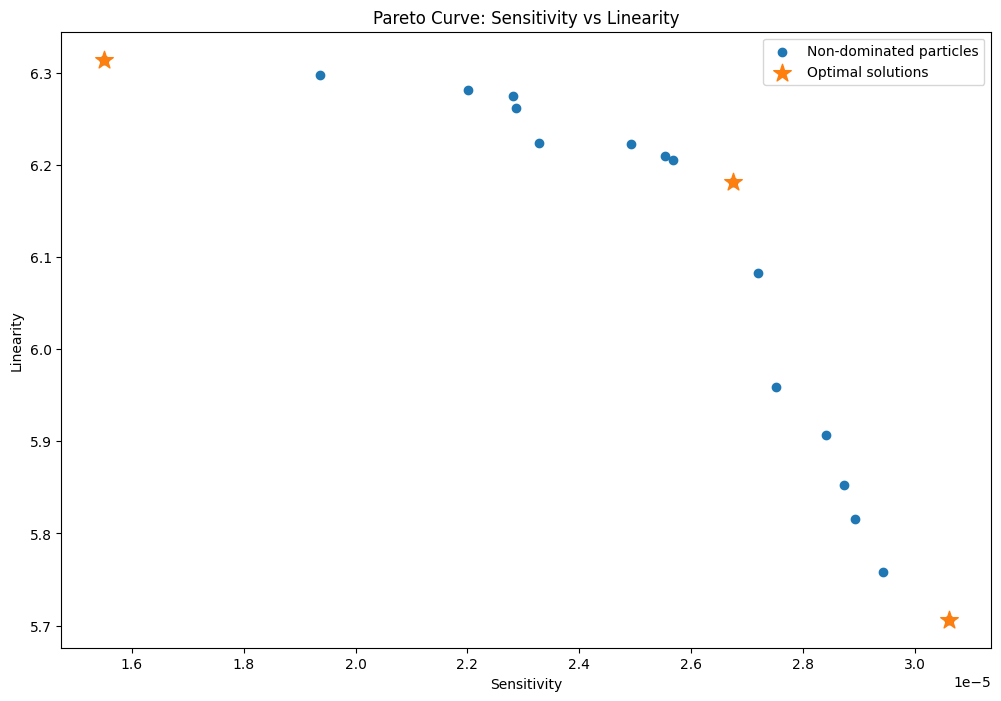

In [72]:
sorted_particles = sorted(gbest, key=lambda best: cost_function(best)[0])

knee_point = find_knee_point(sorted_particles)

solutions = [sorted_particles[0], knee_point, sorted_particles[-1]]

paretto_sensitivity = [cost_function(particle)[0] for particle in solutions]
paretto_linearity = [cost_function(particle)[1] for particle in solutions]

# Plotando o gráfico de Pareto
plt.figure(figsize=(12, 8))

# Pontos não dominados
plt.scatter(y1, y2, marker="o",  label="Non-dominated particles")

# Pontos ótimos
plt.scatter(paretto_sensitivity, paretto_linearity, s=175, marker="*",  label="Optimal solutions")

plt.xlabel("Sensitivity")
plt.ylabel("Linearity")
plt.title("Pareto Curve: Sensitivity vs Linearity")
plt.legend()
plt.show()

In [73]:
for solution in solutions:
    sensors = get_elements_in_chunks(solution)
    print("Solution:")
    for i, sensor in enumerate(sensors):
        print(f"\tSensor {i+1}")
        print("\t\tEspessure (mm):", sensor[0])
        print("\t\tDiameter (mm):", sensor[1])
        print("\t\tPosition (mm):", sensor[2])

Solution:
	Sensor 1
		Espessure (mm): 1.4873493485918106
		Diameter (mm): 25.987537866873854
		Position (mm): 732.0539810208784
	Sensor 2
		Espessure (mm): 1.416652061300413
		Diameter (mm): 12.921126794938381
		Position (mm): 571.668289525464
	Sensor 3
		Espessure (mm): 1.4223665774941225
		Diameter (mm): 11.988655853704907
		Position (mm): 336.7988206341706
	Sensor 4
		Espessure (mm): 1.20850236376342
		Diameter (mm): 10.625072374716865
		Position (mm): 695.542463227146
	Sensor 5
		Espessure (mm): 1.4436015699377462
		Diameter (mm): 21.098508560141696
		Position (mm): 213.11793432281723
	Sensor 6
		Espessure (mm): 1.3178008176584617
		Diameter (mm): 10.274258779803953
		Position (mm): 420.4144733566636
Solution:
	Sensor 1
		Espessure (mm): 1.0273942112418304
		Diameter (mm): 16.179668077908385
		Position (mm): 952.0727143465334
	Sensor 2
		Espessure (mm): 1.1666486100244347
		Diameter (mm): 18.436957334159214
		Position (mm): 861.9690131591472
	Sensor 3
		Espessure (mm): 1.0468088579

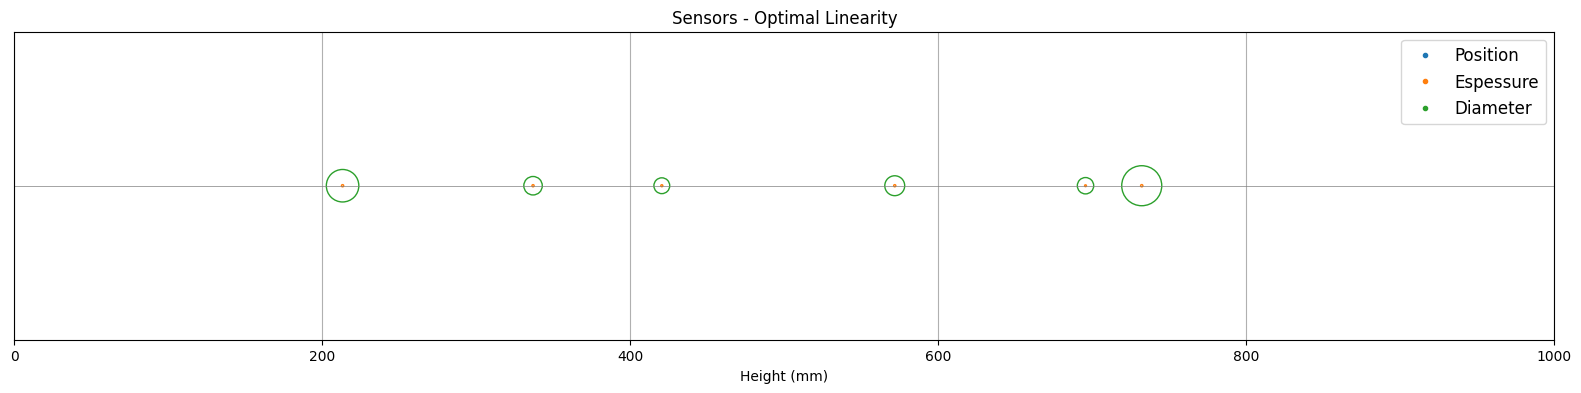

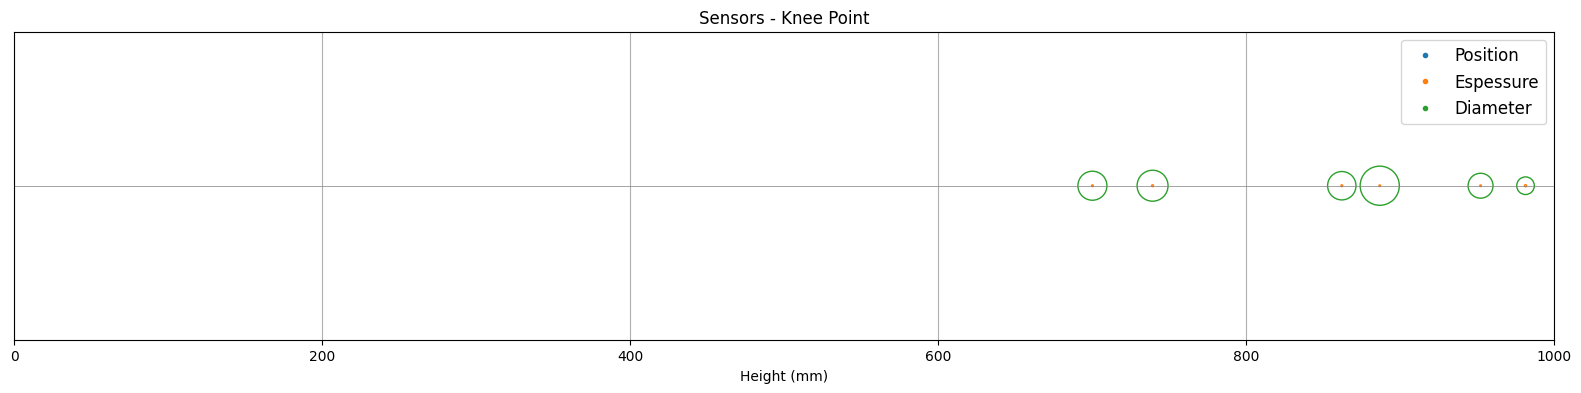

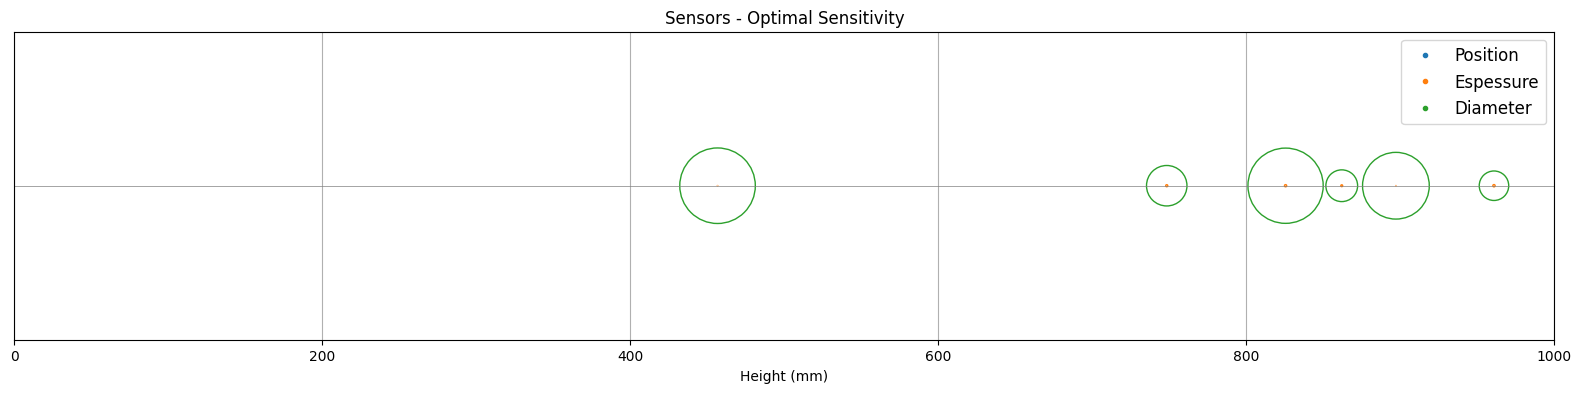

In [74]:
for i, solution in enumerate(solutions):
    # Obtém sensores a partir das posições
    sensors = get_elements_in_chunks(solution)

    # Cria uma figura e um eixo
    plt.figure(figsize=(22, 4))
    ax = plt.gca()
    ax.axhline(y=0, color="gray", linewidth=0.5)

    # Supondo que 'positions' seja uma lista de posições iniciais
    positions = [sensor[POSITION_INDEX] for sensor in sensors]

    # Plotar os pontos iniciais
    ax.plot(
        positions,
        np.zeros(len(positions)),
        ".",
        markersize=0,
        color="#1f77b4",  # Azul
        label="Position",
        linestyle="None",
    )

    # Iterar sobre os pontos e desenhar círculos em volta de cada um
    for sensor in sensors:
        # Desenhar os círculos
        internal_circle = patches.Circle(
            (sensor[POSITION_INDEX], 0),
            sensor[ESPESSURE_INDEX] / 2.0,
            edgecolor="#ff7f0e",  # Laranja
            facecolor="none",
            label="Espessure",
        )
        external_circle = patches.Circle(
            (sensor[POSITION_INDEX], 0),
            sensor[DIAMETER_INDEX] / 2.0,
            edgecolor="#2ca02c",  # Verde
            facecolor="none",
            label="Diameter",
        )

        # Adicionar os círculos ao eixo
        ax.add_patch(internal_circle)
        ax.add_patch(external_circle)

    # Ajustar o aspecto do gráfico para ser igual
    ax.set_aspect("equal", adjustable="box")
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Ajustar o limite do eixo x
    plt.xlim(*BOUNDS_POSITION)
    plt.ylim(-100, 100)

    # Configurar etiquetas e título
    plt.xlabel("Height (mm)")

    if i == 0:
        plt.title("Sensors - Optimal Linearity")
    elif i == 1:
        plt.title("Sensors - Knee Point")
    else:
        plt.title("Sensors - Optimal Sensitivity")

    plt.grid(True, axis="x")

    # Configurar a legenda corretamente
    custom_lines = [
        Line2D(
            [0], [0], color="#1f77b4", marker=".", linestyle="None", label="Position"
        ),
        Line2D(
            [0], [0], color="#ff7f0e", marker=".", linestyle="None", label="Espessure"
        ),
        Line2D(
            [0], [0], color="#2ca02c", marker=".", linestyle="None", label="Diameter"
        ),
    ]
    ax.legend(handles=custom_lines, fontsize=12)

    # Mostrar o gráfico
    plt.show()